In [41]:
from sklearn.datasets import fetch_openml 
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

In [ ]:
#Importando dados

mnist = fetch_openml('mnist_784',version=1,as_frame=False)

In [4]:
X, y = mnist['data'],mnist['target']
X.shape
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

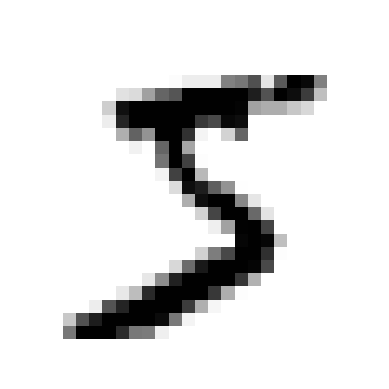

In [12]:
#Visualizando imagens 

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation='nearest')
plt.axis('off')


In [14]:
#Transformando target em númerica

y = y.astype(np.uint8)

In [15]:
#Dividindo datasets em treino e teste 

X_train,X_test,y_train,y_teste = X[:60000],X[60000:],y[:60000],y[60000:]

In [25]:
#Treinando um classificador binário 

y_train_5 = y_train == 5
y_test_5 = y_teste == 5
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [26]:
#Prevendo o primeiro número 5

sgd_clf.predict([some_digit])

array([ True])

In [28]:
#Aplicando validação cruzada

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [31]:
#Comparando a acurácia do modelo com um modelo dum 

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5clf = Never5Classifier()
cross_val_score(never_5clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [36]:
#Confusion Matrix 

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

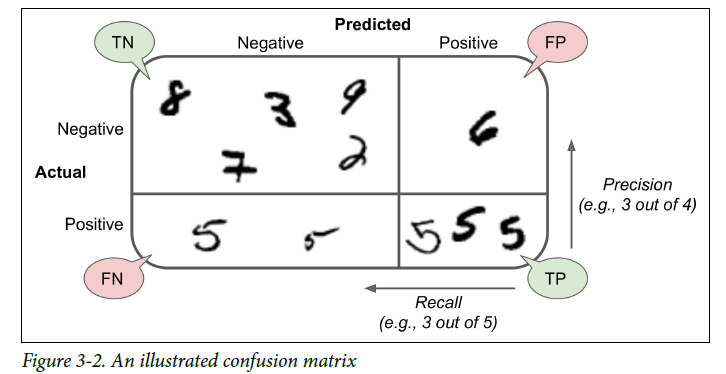

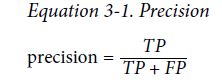

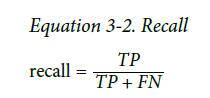

Basicamente, precisão é a taxa de acerto daquilo que o modelo classifica como positivo e recall é a taxa de acerto do modelo em relação a todas as classes positivas.

In [40]:
print("Precisão:" ,precision_score(y_train_5,y_train_pred), ' Recall:', recall_score(y_train_5,y_train_pred))

Precisão: 0.8370879772350012  Recall: 0.6511713705958311


In [42]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846